<a href="https://colab.research.google.com/github/gysdnow/NLPWorks/blob/master/BERTForClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT文本分類
輸入文本長度，最長支援至512，故須針對大於此長度的文本進行切割，
但在字串長度設定為512時，會占用相當多記憶體資源
故此處按照[此文](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d)
作法，將長文切割成 200 字且 OVERLAP 50字的子集合，再根據原文及預測結果投票取情緒值。

---



##資料集說明
攜程網-酒店評論資料
ChnSentiCorp_htl_all 

5322 Postive, 

2444 Negtive, 

[資料來源](https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb)


In [0]:
import pandas as pd

In [0]:
#Colab
path = 'drive/My Drive/Colab Notebooks/'
#Local
#path = './'
raw_df = pd.read_csv(path + 'ChnSentiCorp_htl_all.csv')
raw_df.label.value_counts()

1    5322
0    2444
Name: label, dtype: int64

#觀察文章字數分布

平均:367字

中位數:300字

In [0]:
raw_df[raw_df.review.str.len()>200].review.str.len().describe()

count    1307.000000
mean      367.745218
std       206.539704
min       201.000000
25%       238.500000
50%       300.000000
75%       425.000000
max      2924.000000
Name: review, dtype: float64

#觀察長文(大於兩百字)占比

X軸:篇數

y軸:文本字數

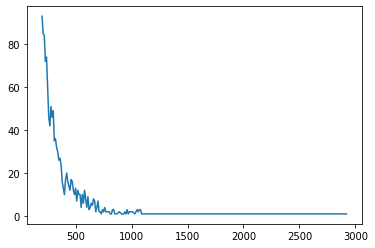

In [0]:
raw_df[raw_df.review.str.len()>200].review.str.len().map(lambda x: (int(x/10)) * 10).value_counts().sort_index().plot()

#文本分割程式碼
假設有一篇文本總長 500 個字，<br />
取 1 ~ 200 作為   Sub1<br />
取 150 ~ 350 作為 Sub2<br />
取 300 ~ 500 作為 Sub3<br />


In [0]:
#切割成200 overlap 50 的子集合
def get_split(text):
  text = str(text)
  text_total_len = 200 #default:200
  text_overlap = 50 #default:50
  text_len = text_total_len - text_overlap
  
  l_total = []
  l_parcial = []
  #如果 Input 總字數大於149
  if len(list(text))//text_len >0:
    # n = Input可以被切成幾個長度為 150 的小文本
    n = len(list(text))//text_len
  else: 
    n = 1

  for w in range(n):
    #第一個小文本
    if w == 0:
      #將文本轉成每個字的LIST
      #從 index = 0 取至 200
      l_parcial = list(text)[:text_total_len]
      #合起來 放進TOTAL
      l_total.append("".join(l_parcial))
    else:
      #取 (第 w 個文本 * 150) + 200
      # w = 1 : 150 ~ 350
      # w = 2 : 300 ~ 500 ...
      l_parcial = list(text)[ w * text_len : w * text_len + text_total_len]
      l_total.append("".join(l_parcial))
  return l_total

# 切割文本，形成新的欄位  > df['review_split']
> 驗證切割狀況

目標文本: ABCDEFGHIJK

LENGTH = 5, OVERLAP = 2,

子文本1 =ABC**DE**<br />
子文本2 ===>DEF**GH**<br />
子文本2 ======>GHIJK<br />



In [0]:
raw_df['review_split'] = raw_df.review.apply(get_split).reset_index(drop=True)

#將小文本的末50字換行做驗證
test = [[x[:150],x[150:]]for x in raw_df.review_split[92]]

for t in test:
  print('Text = [{}] \nOverlap = [{}]\n'.format(t[0],t[1]))

Text = [我们从6月21日到6月25日在亚太(二期)一共住了四个晚上,原本想在这个酒店住两天,再到亚龙湾住两天,但我老公觉得这样太累了,所以就没有定其他酒店,现在想想觉得有些后悔.首先,亚太国际会议中心的服务的确不错,差不多每天见到的服务员都能主动与客人打招呼,而且非常亲切(但除了三期中餐厅的收银员,态度较冷] 
Overlap = [淡);宾馆大堂还是比较漂亮的,游泳池也很美,由于我事先再三要求住在五楼,而且一定要100%海景房,所]

Text = [淡);宾馆大堂还是比较漂亮的,游泳池也很美,由于我事先再三要求住在五楼,而且一定要100%海景房,所以携程这点也尽量做到了(在此表示感谢),房间比较陈旧,连我不讲究的老公都觉得不太符合五星级的标准,但是厕所是兰色的主题,很干净,很大,我和我儿子都很喜欢.早上起床,我迫不及待地打开厚厚的窗帘,给我的第] 
Overlap = [一感觉就是:美极了!棒极了!这家酒店的早饭一般般,由于我们连住了四天,每天吃的都差不多,品种看上去蛮]

Text = [一感觉就是:美极了!棒极了!这家酒店的早饭一般般,由于我们连住了四天,每天吃的都差不多,品种看上去蛮多的,但味道实在不敢恭维,而且最要命的是除了房间,前台(有一个立式空调)以外,酒店的任何地方都没有空调(连吊扇也没有),我们早上每天都吃得大汗淋淋,热得实在是吃不消.但餐厅环境还是不错的.我们去了一次] 
Overlap = [三期吃饭,感觉环境比二期要好,而且餐厅有中央空调(但那里似乎服务员都不怕热,即使有空调也不开).总的]

Text = [三期吃饭,感觉环境比二期要好,而且餐厅有中央空调(但那里似乎服务员都不怕热,即使有空调也不开).总的来讲:服务不错,环境不错,离大海沙滩很近,三亚是个很美的地方,我和儿子走的时候都有些依依不舍,但是由于三亚本身是个很热的地方,这个酒店没有空调,太热了,所以下次去的话除非冬季去会住在那里,其余季节不会] 
Overlap = [再住这个酒店了(真是觉得很可惜)]



#長文切割後，重新整理資料集
多出來的子文本，沿用原文的LABEL

紀錄子文本是由哪篇原文所切割 (index)

並檢查新資料集字數分布


In [0]:
train_l = []
label_l = []
index_l = []
for idx,row in raw_df.iterrows():
  for rs in row['review_split']:
    train_l.append(rs)
    label_l.append(row['label'])
    index_l.append(idx)

print(len(train_l),len(label_l),len(index_l))
new_df_with_idx = pd.DataFrame({'text':train_l, 'label':label_l, 'idx':index_l})
new_df = pd.DataFrame({'text':train_l, 'label':label_l ,'idx':index_l})
#new_df.astype({'label': 'float'}).dtypes
new_df.head()

8996 8996 8996


,text,label,idx
0,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较...",1,0
1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!,1,1
2,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。,1,2
3,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...,1,3
4,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风",1,4


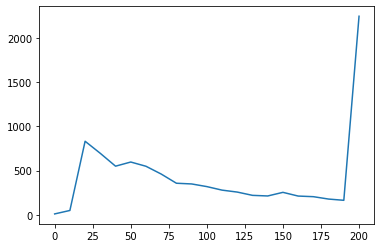

In [0]:
#驗證目前文本字數分布
new_df.text.str.len().map(lambda x: (int(x/10)) * 10).value_counts().sort_index().plot()

#儲存處理結果
隨機分為訓練集、驗證集

In [0]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(new_df, random_state=777, train_size=0.8)
#存檔
train_data.to_csv('./train_data.tsv', index=False, sep='\t', encoding='utf-8')
valid_data.to_csv('./valid_data.tsv', index=False, sep='\t', encoding='utf-8')

# 將資料格式為 BERT 輸入格式
- 使用Bert Base Chinese 模型
- 首位加入 [CLS]、文本轉換為TOKEN、TOKEN轉為TENSOR
- RETURN 三種 TENSOR :
  
  1.TOKEN(內容)

  2.SEGMENT(前後句)

  3.LABEL(標籤)


In [0]:
!pip install transformers -q
!pip install pysnooper -q
import pysnooper
import torch
from transformers import BertTokenizer,BertForSequenceClassification
from IPython.display import clear_output


PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

from torch.utils.data import Dataset
class CommentDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "valid"] #限制只有這兩種模式
        self.mode = mode 
        self.df = pd.read_csv(mode + "_data.tsv", sep="\t").fillna("") #讀對應檔案
        self.len = len(self.df)  
        self.tokenizer = tokenizer  #欲使用的token轉換器
    
    def __getitem__(self, idx):
        #如果是驗證集，不讀取LABEL
        if self.mode == "valid":
            text = self.df.iloc[idx].text
            label_tensor = None
        else:
            text, label = self.df.iloc[idx ,:2].values
            label_tensor = torch.tensor(label,dtype=torch.long)
            
        #[CLS] Sentence Token
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens
        
        len_a = len(word_pieces)
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        segments_tensor = torch.tensor([0] * len_a ,dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
trainset = CommentDataset("train", tokenizer=tokenizer)
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞


#批次提供資料
- RETURN 四種 TENSOR :

  1.TOKEN (內容、已加入[PAD]統一長度)

  2.SEGMENT (前後句、已加入[PAD]統一長度)

  3.MASK (BERT模型可MASK的範圍)

  4.LABEL (標籤)

In [0]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    #取出TOKEN(內容)的TENSOR
    tokens_tensors = [s[0] for s in samples]
    #取出SEGMENT(前後句)的TENSOR（判斷上下句關係時需使用,目前全放0即可）
    segments_tensors = [s[1] for s in samples]
    
    #檢查輸入的資料集有沒有 label 資料
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    #將長短不一的TENSORS tensor 統一用 [PAD] 補齊長度
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    #將TOKENS.SHAPE[0]的長度填0，其他填1
    #藉以約束 BERT 可 MASK 的 TENSOR在句子內
    #不至於跑到 [PAD] 處 (MASK PAD無助於 BERT 訓練)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


#設定BERT相關參數
建立 DATA LOADER

建立 BERT MODEL




In [0]:
#Colab GPU RAM 的關係,取batch size = 32
BATCH_SIZE=32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                         collate_fn = create_mini_batch)

#LABELS 有幾種類別
NUM_LABELS = 2

#建立 BertForSequenceClassification model 
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name            module
----------------------""")

for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=2, bias=True)


#預測資料 Function
- (model.eval) or (torch.no_grad)? [Link](https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615)


- torch.max(a,axis) 取得該 axis 中最大值及其 index<br />
axis=0 > col<br />
axis=1 > row<br />

## 範例:

```python
>>> a = [[1,2,3],[2,3,4],[9,0,1]]
>>> torch.max(a,1)
3
4
9
[torch.FloatTensor of size 3]
,
2
2
0
[torch.LongTensor of size 3]
```


In [0]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            #取出前三個Return值
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            #填入Model
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            logits = outputs[0]
            #取出該row最大值及其索引()
            #最大值為機率、索引為0,1
            #即BERT所分類之標籤
            _, pred = torch.max(logits.data, 1)
            #如果要算準確率
            if compute_acc:
                #取出dataloader第四個Return list
                labels = data[3]
                #總數等於 default 0 + labels個數
                total += labels.size(0)
                #預測值等於label的數量加總
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

#開始 FineTune Bert模型

In [0]:
%%time

#有GPU用GPU，沒有的話就用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
#將目前 model 上的數值都 Copy 一份到 device 上
#後續將在該device上操作
model = model.to(device)
model.train()
#優化器選用Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#跑9個epoch
EPOCHS = 9  

for epoch in range(EPOCHS):
    running_loss = 0.0
    # 1 個epoch 跑 n 次Batch
    # 每次 batch 都是一個step
    for data in trainloader:
        #找trainloader拿資料
        #分別放置對應的 list變數
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]
        #歸零梯度參數
        optimizer.zero_grad()
        #將輸入值塞進 model
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        #此處output值第一個變數是loss
        #有提供label作為input時，第一個值會是loss
        #沒有提供時，第一個值會是logits
        loss = outputs[0]
        #反向傳播模型參數
        loss.backward()
        #優化器更新參數
        optimizer.step()

        running_loss += loss.item()
        
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))
    

device: cuda:0
[epoch 1] loss: 72.974, acc: 0.908
[epoch 2] loss: 51.638, acc: 0.942
[epoch 3] loss: 39.893, acc: 0.959
[epoch 4] loss: 28.635, acc: 0.969
[epoch 5] loss: 22.107, acc: 0.980
[epoch 6] loss: 15.166, acc: 0.978
[epoch 7] loss: 11.658, acc: 0.983
[epoch 8] loss: 8.946, acc: 0.966
[epoch 9] loss: 10.866, acc: 0.994
CPU times: user 19min, sys: 9min 36s, total: 28min 36s
Wall time: 28min 37s


# 訓練完成，進行預測

In [0]:
validset = CommentDataset('valid',tokenizer=tokenizer)
validloader = DataLoader(validset, batch_size=64, 
                        collate_fn=create_mini_batch)
valid_predictions = get_predictions(model, validloader)

In [0]:
valid_df_pred = pd.DataFrame({"predicted": valid_predictions.tolist()})
valid_df = pd.concat([validset.df, valid_df_pred.loc[:, 'predicted']], axis=1)
valid_df.head()

,text,label,idx,predicted
0,第一次住这里，之前有同事住过，所以觉得应该还可以，没想到：1、门童非常不主动，门口站着几个门...,0,5535,0
1,家庭式旅馆，吵架，不干净。莫干山庄很好，但是携程上没有，还有山上有10多家酒店，携程只有2－...,0,6825,0
2,没住过这么差的酒店。首先不能刷卡。而且服务质量极差，我刚到时安排房间是未打扫的，再安排还是没...,0,5687,0
3,我3.6预定好的180的标间，当我到的时候竟然说有会议房间满了，我订的房间没有了，太不讲信誉...,0,5330,0
4,"酒店的环境,房间和服务都不错,但是门口的保安就很差.让人联想到""打手"".再加上网上也有对保安...",1,3562,1


#檢查預測結果
找出 [BERT預測值] 與 [LABEL] 相異的文本
透過觀察相異文本可以看出 

BERT 是否確實找出判斷類別的特徵依據

最後再將預測結果按照 [原文idx] 進行合併

In [0]:
diff_df = valid_df[valid_df.label != valid_df.predicted].reset_index(drop=True)

BERT 預測為負、資料集標註為正


In [0]:
diff_df[diff_df.label==1].sample(10)

,text,label,idx,predicted
23,房间还算可以，但硬件设施偏差，服务水平也很一般。,1,4969,0
129,空调，现在全部设定的温度是27-28度，晚上就会好点，真难受！这就是五星级酒店，晚上上半夜的...,1,2483,0
78,五一住了这里，作为三星级硬件还可以。前台经理赞一个，我们一行在隔壁吃饭，发票中了奖，但饭馆就...,1,248,0
81,作为酒店的老客户，恐怕以后要做另外的选择了――服务水平在下降，价格却一升再升，再这样下去，下...,1,4013,0
70,五星根本不符合五星标准。房间小就不说了，洗浴品只有洗发水，没有浴袍，茶水篮里仅有一包绿茶。卫...,1,694,0
10,晚上10点至凌晨4点之间骚扰电话太多，常常无法入睡，给总台反映过，但是没有起到作用！,1,1006,0
143,专业公司对新装修楼层的楼道，房间进行了光触媒净化处理。光触媒是一种无毒无害的健康型净化空气材...,1,2078,0
101,我很晚才住进酒店，打车过去，从大门到我住的那栋，走了好久，本来已经疲惫不堪，还走了那么远一段...,1,4922,0
149,"从乌鲁木齐火车站打的过去11块钱,在解放北路,离乌鲁木齐的二道桥市场也不远,可以去买干果,也...",1,978,0
123,"多都是以自制的霸王条款来约束客人,甚至超越其权限对客人进行经济处罚,这本身就是对""服务""和""...",1,940,0


BERT 預測為正、資料集標註為負

In [0]:
fix_df[fix_df.label==0].sample(10)

,text,label,idx,predicted
141,豪华大床房房间大小一般，墙壁看起来很不舒服，都有掉落的斑驳痕迹，其他一般，在所有住过的经济型...,0,6919,1
92,房价较贵，位置也比较偏，房屋隔音效果较差。屋外说话，里面的清清楚楚。不是每间房间都有宽带，我...,0,5417,1
28,房间整洁，空间狭小，椅子和床之间太近了，坐在桌前不舒服，电视为吊挂式，只能躺在床上看，而且必...,0,6467,1
111,优点：地处繁华，服务员很友好。缺点：因为靠马路，晚上很吵，一夜没睡好。第二天中午回到房间，发...,0,5766,1
113,很一般的酒店，紧临马路，虽然有双层窗，但还有些吵。平时价格应低于200元，节日价格380元属...,0,7433,1
115,都有。这个有点虚假宣传。3、热水器因为水压的问题，冷热不定。不冻死你算你运气。4、洗澡间没有...,0,5499,1
27,房间还可以，比较大，但是临近马路，早上被车辆声音吵醒了，还有就是桑拿浴室不好，洗了一次澡，我...,0,5340,1
71,地理位置还不错，到哪里都比较方便，但是服务不象是豪生集团管理的，比较差。下午睡了一觉并洗了一...,0,5324,1
77,"开始住的那个房间初看感觉不错，但空调坏的,一晚没用,卫生间淋浴房洗澡时往外漏水.后来换了一个...",0,6638,1
127,房间外声音太大，比较吵闹！直接到前台预定费用更合理。,0,5769,1


# 按照 原文idx 合併結果
透過idx取預測值的平均

In [0]:
valid_df.groupby(['idx']).agg('mean').predicted.value_counts()

1.000000    1094
0.000000     609
0.500000      11
0.333333       1
0.666667       1
Name: predicted, dtype: int64

In [0]:
z = valid_df.groupby(['idx']).agg('mean').reset_index()
z[(z.predicted >0) & (z.predicted<1)]

,idx,label,predicted
9,62,1.0,0.500000
248,1143,1.0,0.333333
315,1473,1.0,0.500000
367,1685,1.0,0.666667
446,2078,1.0,0.500000
540,2483,1.0,0.500000
694,3207,1.0,0.500000
831,3878,1.0,0.500000
1209,5652,0.0,0.500000
1214,5663,0.0,0.500000


# 預測值平均為0.33的案例
(為方便閱讀 用逗號斷行)

In [0]:
print('\n'.join(raw_df.review[1143].split('，')))

注意啦！！这个酒店只有6、7楼重新装修过（地毯是深灰色）。其他都是旧装修。我们出住时
提出要看房间
前台安排我们看了6楼。是不错的装修。地毯是新的。没有什么异味。但5楼是该酒店的KTV
很吵。但5楼的房里能听到楼下唱歌及微微的震动。所以我决定不选五楼。我问服务员
这房间是新装修的吗？因为看到洗手间的配置很新。他回答我不是
全酒店都一样。回到前台
他们给我安排了13楼。心想不错嘛。结果与朋友拖着行李到了13楼
电梯一开
已看到是旧地毯
污积斑斑。进了房间
一鼓酸臭味！洗手间也不是5楼的配置。。。差异太大了。结果

我们做了有史以来最经典的事。。。因错按了一层号码
电梯门一开
发现也是旧装修（旧地毯
浅色大花）补充点评2007年10月10日：结果
我们决定每一层都看一下地毯来决定来入住哪一层
因我10.1期间自驾车去玩
共入住过6晚不同的酒店
前一天入住[杭州]杭州最佳西方梅苑宾馆
就是因为只相信了CTRIP的网评
在没有看房间的情况下入住了
房间感觉很不好
根本与四星不相配
所以这次一定要选好一点。我们坐电梯每一层都看了一眼地毯（当时已晚上10点
没有什么客人来往
所以我们不会打扰到其他人用电梯
而且有4台电梯的）发现只有7楼是新地毯
还是11楼及15楼是比较干净的旧款地毯（主要是霉气味不太重。来到前台要求换房
转7楼或11楼。前台也不说什么
同意换。但告之：7楼已客满。11楼是行政楼层
要加100元。最后
我们选了15楼。。要求非吸烟房。前台同意。进房

还是有点霉气味
但比11楼小。最好笑就是看到服务员从房间里拿走烟灰缸

哈哈！！！这就是非吸烟房！！服务员给我们打开窗户
说吹一下风
味道就没有了。天呀！！四星酒店！！！真是只有6楼的配置比较合符四星。。但5楼的噪音又将此优势给去掉了。。。但酒店对面另一家“皇冠”酒店也是四星的。比它更不好
所以
还是住下了。。这间酒店是唯一一间要退房时
查有没有东西要赔
之类的。。我前几天住三星的酒店都没有这个要求！还有
房价是298
我订了两个房共一晚
酒店要求压金2000元！
